In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
df = pd.read_csv('Energy_consumption.csv')

In [28]:
df.isnull().sum()

Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

In [29]:

# Drop rows with NaN values
dataset = df.dropna()

# Display the shape and first few rows to confirm
print(dataset.shape)
print(dataset.head())

(1000, 11)
       Timestamp  Temperature   Humidity  SquareFootage  Occupancy HVACUsage  \
0  1/1/2022 0:00    25.139433  43.431581    1565.693999          5        On   
1  1/1/2022 1:00    27.731651  54.225919    1411.064918          1        On   
2  1/1/2022 2:00    28.704277  58.907658    1755.715009          2       Off   
3  1/1/2022 3:00    20.080469  50.371637    1452.316318          1       Off   
4  1/1/2022 4:00    23.097359  51.401421    1094.130359          9        On   

  LightingUsage  RenewableEnergy  DayOfWeek Holiday  EnergyConsumption  
0           Off         2.774699     Monday      No          75.364373  
1            On        21.831384   Saturday      No          83.401855  
2           Off         6.764672     Sunday      No          78.270888  
3            On         8.623447  Wednesday      No          56.519850  
4           Off         3.071969     Friday      No          70.811732  


In [30]:
categorical_features = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
# drop_first avoids multicollinearity
data_encoded = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)  

# Display the transformed data with encoded features
print(data_encoded.shape)
print(data_encoded.head())

(1000, 16)
       Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0  1/1/2022 0:00    25.139433  43.431581    1565.693999          5   
1  1/1/2022 1:00    27.731651  54.225919    1411.064918          1   
2  1/1/2022 2:00    28.704277  58.907658    1755.715009          2   
3  1/1/2022 3:00    20.080469  50.371637    1452.316318          1   
4  1/1/2022 4:00    23.097359  51.401421    1094.130359          9   

   RenewableEnergy  EnergyConsumption  HVACUsage_On  LightingUsage_On  \
0         2.774699          75.364373          True             False   
1        21.831384          83.401855          True              True   
2         6.764672          78.270888         False             False   
3         8.623447          56.519850         False              True   
4         3.071969          70.811732          True             False   

   DayOfWeek_Monday  DayOfWeek_Saturday  DayOfWeek_Sunday  DayOfWeek_Thursday  \
0              True               False         

In [31]:
# List of numerical columns
numerical_columns = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']

In [32]:
# Calculate Z-scores for numerical columns
z_scores = data_encoded[numerical_columns].apply(zscore)
#print(z_scores)
# Identify outliers (z-score > 3 or z-score < -3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers detected using Z-scores: {outliers.sum()}")

Number of outliers detected using Z-scores: 0


In [33]:
#Isolation Forest
# Select relevant numerical features for outlier detection
# This could include all columns or a subset, depending on the context
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']
data_for_iforest = data_encoded[features]

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination level based on the dataset
outlier_predictions = iso_forest.fit_predict(data_for_iforest)

# Add predictions back to the dataset for interpretation
data_encoded['Outlier'] = outlier_predictions  # -1 indicates an outlier, 1 indicates an inlier

# Count the outliers
num_outliers = (data_encoded['Outlier'] == -1).sum()
print(f"Number of outliers detected: {num_outliers}")

# Optional: Separate outliers and inliers for further analysis
outliers = data_encoded[data_encoded['Outlier'] == -1]
inliers = data_encoded[data_encoded['Outlier'] == 1]

data_cleaned = data_encoded[data_encoded['Outlier'] == 1].drop(columns=['Outlier'])  # Keep only inliers, drop 'Outlier' column

# Display the cleaned data shape and a preview
print(f"Data shape after outlier removal: {data_cleaned.shape}")
#print(data_cleaned.head())

Number of outliers detected: 10
Data shape after outlier removal: (990, 16)


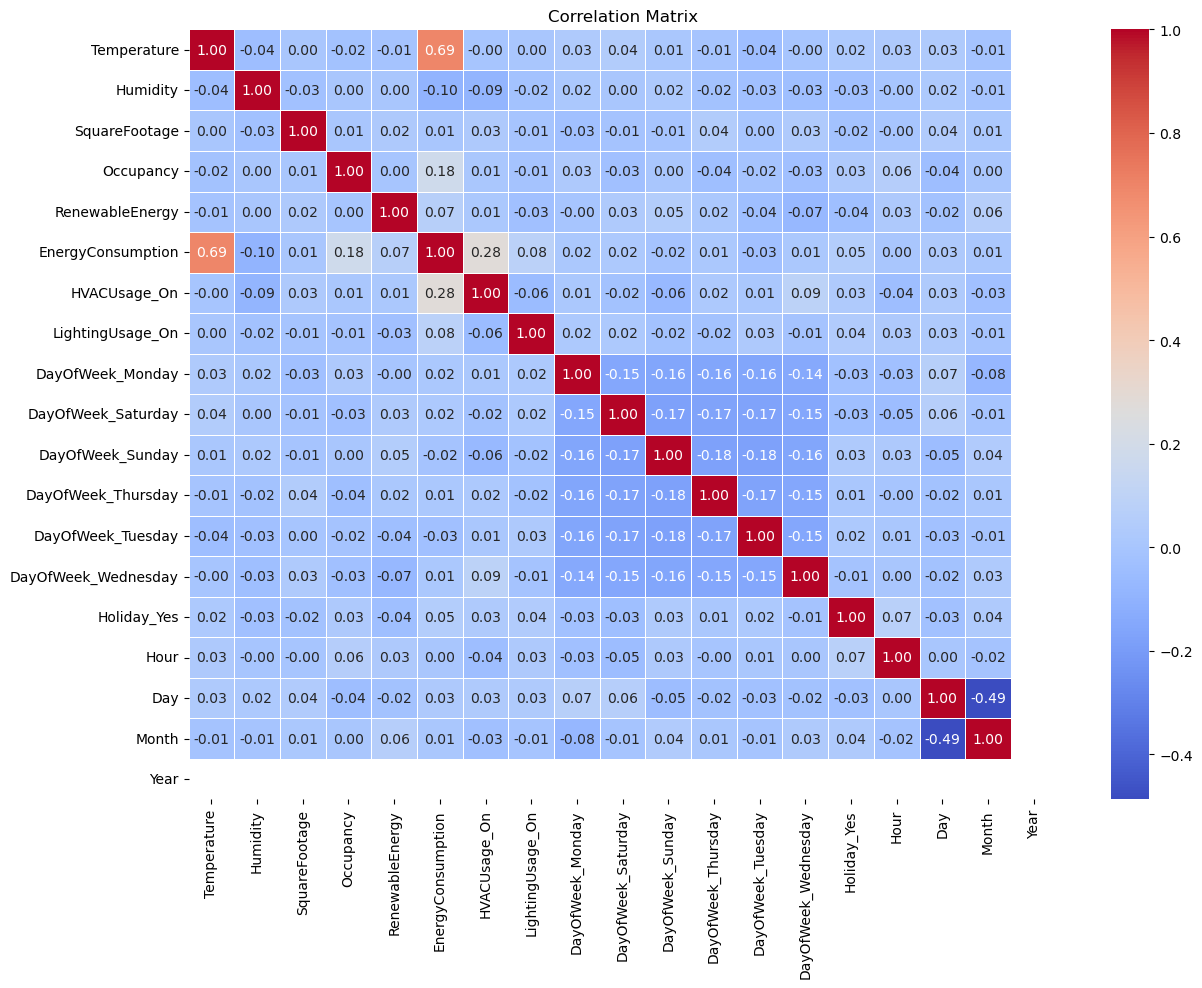

In [34]:
#correleation matrix
# Convert boolean columns to integers
boolean_columns = data_cleaned.select_dtypes(include='bool').columns
data_cleaned[boolean_columns] = data_cleaned[boolean_columns].astype(int)

# Convert 'Timestamp' to datetime
data_cleaned['Timestamp'] = pd.to_datetime(data_cleaned['Timestamp'])

#convert timestamp into date hour month and year 
data_cleaned['Hour'] = data_cleaned['Timestamp'].dt.hour
data_cleaned['Day'] = data_cleaned['Timestamp'].dt.day
data_cleaned['Month'] = data_cleaned['Timestamp'].dt.month
data_cleaned['Year'] = data_cleaned['Timestamp'].dt.year

# Drop the original 'Timestamp' column
data_cleaned = data_cleaned.drop(columns=['Timestamp'])

# Calculate the correlation matrix
correlation_matrix = data_cleaned.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [35]:
data_cleaned = data_cleaned.drop(columns=['Year'])
print(data_cleaned.head())

   Temperature   Humidity  SquareFootage  Occupancy  RenewableEnergy  \
0    25.139433  43.431581    1565.693999          5         2.774699   
1    27.731651  54.225919    1411.064918          1        21.831384   
2    28.704277  58.907658    1755.715009          2         6.764672   
3    20.080469  50.371637    1452.316318          1         8.623447   
4    23.097359  51.401421    1094.130359          9         3.071969   

   EnergyConsumption  HVACUsage_On  LightingUsage_On  DayOfWeek_Monday  \
0          75.364373             1                 0                 1   
1          83.401855             1                 1                 0   
2          78.270888             0                 0                 0   
3          56.519850             0                 1                 0   
4          70.811732             1                 0                 0   

   DayOfWeek_Saturday  DayOfWeek_Sunday  DayOfWeek_Thursday  \
0                   0                 0                   0

In [36]:
pip install SHAP

Note: you may need to restart the kernel to use updated packages.


Mean Absolute Error (MAE): 4.22
Mean Square Error (MSE): 27.43
Root Mean Squared Error (RMSE): 5.24
R² Score: 0.58

Feature Importances:

Feature Importance (Formatted Table):
+----+---------------------+--------------+
|    | Feature             |   Importance |
+====+=====================+==============+
|  0 | Temperature         |   0.549069   |
+----+---------------------+--------------+
|  1 | HVACUsage_On        |   0.0710859  |
+----+---------------------+--------------+
|  2 | RenewableEnergy     |   0.0663408  |
+----+---------------------+--------------+
|  3 | Occupancy           |   0.0627797  |
+----+---------------------+--------------+
|  4 | Day                 |   0.0527237  |
+----+---------------------+--------------+
|  5 | SquareFootage       |   0.0521898  |
+----+---------------------+--------------+
|  6 | Humidity            |   0.0503895  |
+----+---------------------+--------------+
|  7 | Hour                |   0.0388538  |
+----+---------------------+----

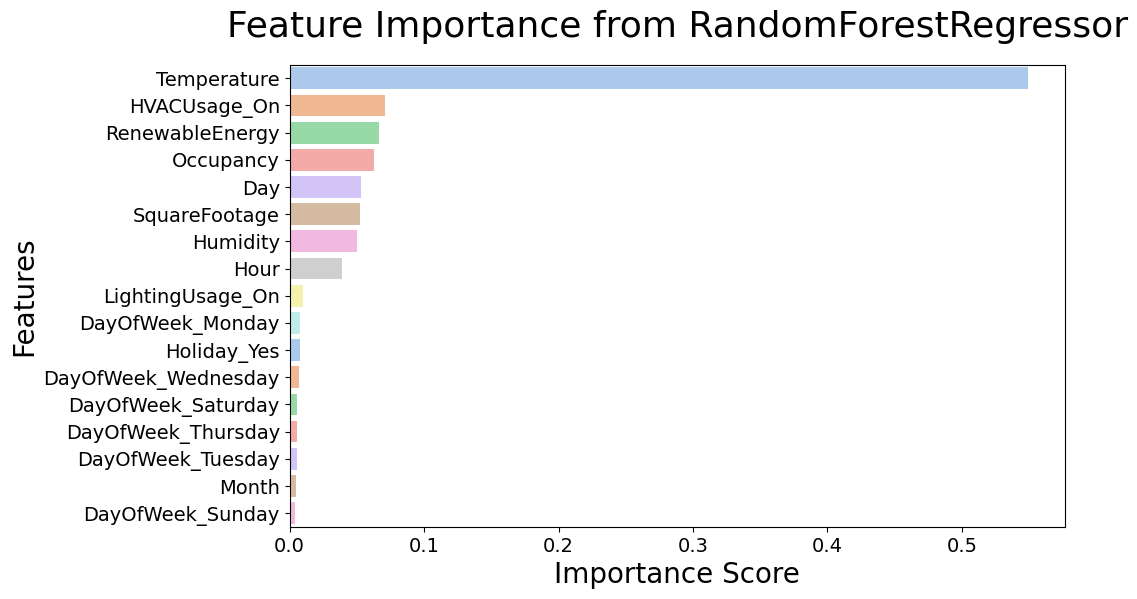

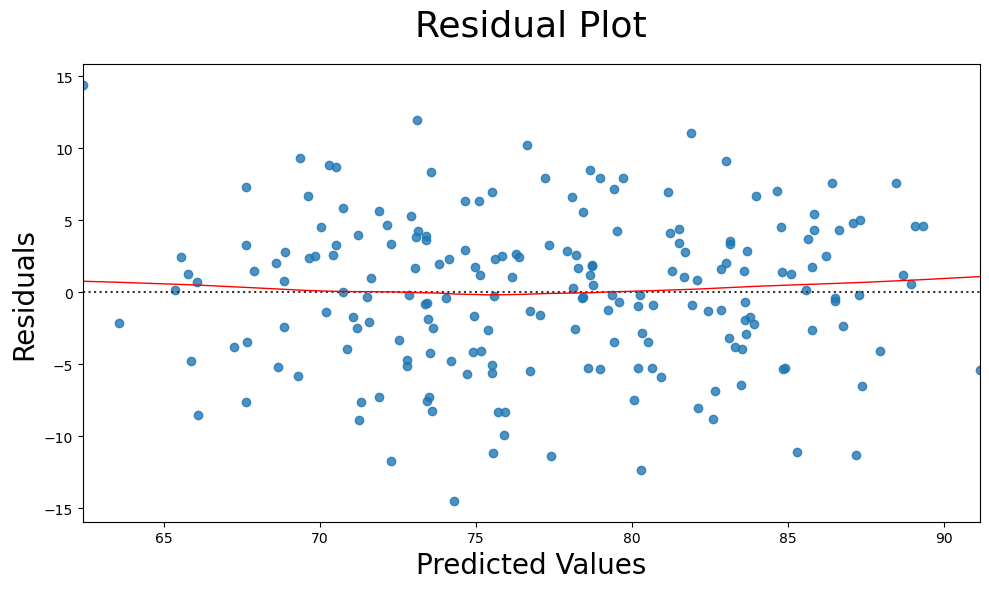

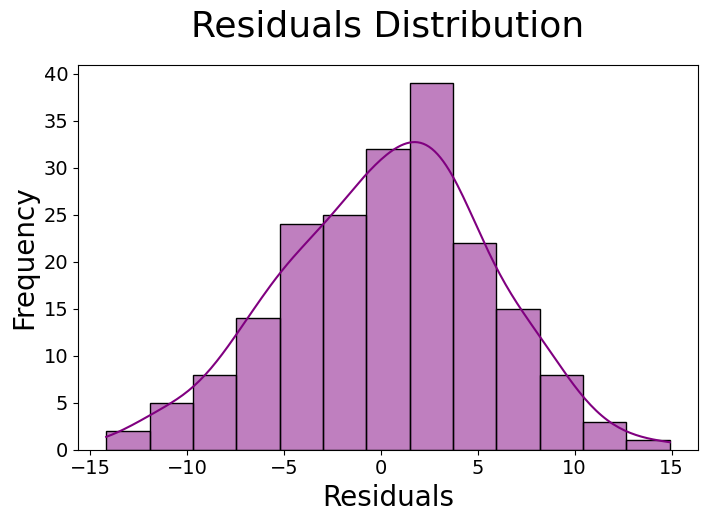

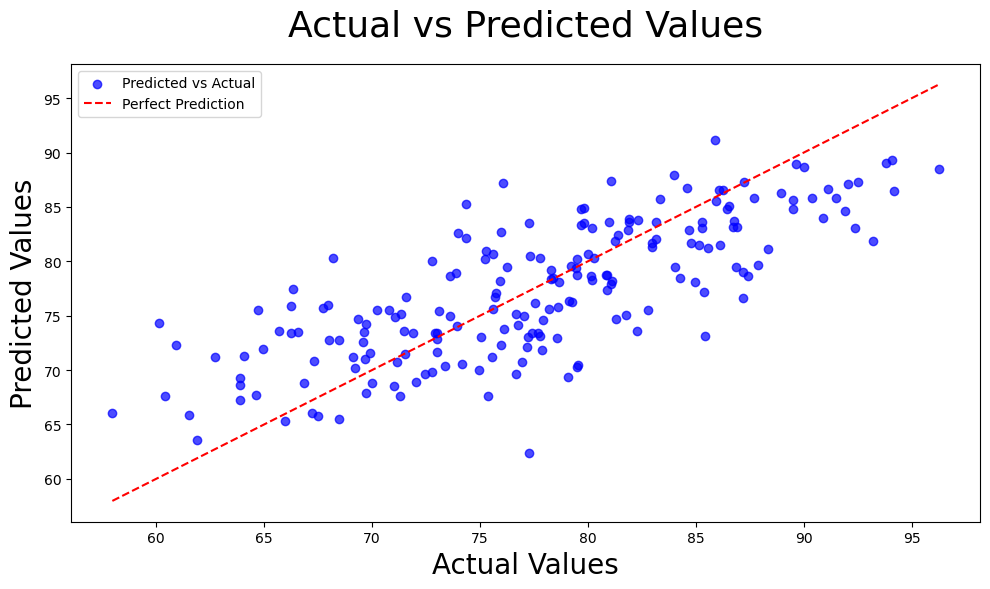

In [17]:
# RandomForestRegressor model with Non Important Features Removed using the mean importance score as a threshold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap


# Step 1: Prepare the data
# Define features (all columns except 'EnergyConsumption') and target (EnergyConsumption)
X = data_cleaned.drop(columns=['EnergyConsumption'])
y = data_cleaned['EnergyConsumption']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 4: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 5: Analyze Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display feature importances
print("\nFeature Importances:")
#print(feature_importances)
try:
    from tabulate import tabulate
    # Convert Series to DataFrame
    feature_importances_df = feature_importances.reset_index()
    feature_importances_df.columns = ['Feature', 'Importance']
    print("\nFeature Importance (Formatted Table):")
    print(tabulate(feature_importances_df, headers='keys', tablefmt='grid'))
except ImportError:
    pass
    
# Save the feature importance table to a CSV file
feature_importances_df.to_csv(r'C:\Users\msrib\Documents\Stat Learning\Final project\feature_importances.csv', index=False)

# Step 6: Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='pastel' , hue=feature_importances.index)
plt.title('Feature Importance from RandomForestRegressor',fontsize= 26 ,pad=20)
plt.xlabel('Importance Score',fontsize= 20)
plt.ylabel('Features',fontsize= 20)
# Optionally, further customize tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Feature Importance from RandomForestRegressor.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate residuals (errors between actual and predicted values)
residuals = y_test - y_pred

# Create residual plot
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})

# Add labels and title
plt.xlabel('Predicted Values', fontsize= 20)
plt.ylabel('Residuals', fontsize= 20)
plt.title('Residual Plot', fontsize= 26, pad=20)

# Display the plot
plt.tight_layout()
plt.show()

# Step 6: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution',fontsize= 26, pad = 20)
plt.xlabel('Residuals', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('Residual Plot (Error Analysis).png', dpi=300, bbox_inches='tight')
plt.show()


# Assuming y_test is the actual values and y_pred is the predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')

# Plot the line y = x (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Values',fontsize= 20)
plt.ylabel('Predicted Values',fontsize= 20)
plt.title('Actual vs Predicted Values',fontsize= 26 ,pad=20)
plt.savefig('Scatter plot of actual vs predicted values.png', dpi=300, bbox_inches='tight')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [37]:
# Test with meanfeature threshold Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



# Calculate the mean importance score
mean_importance = feature_importances.mean()

# Select features with importance score above the mean threshold
selected_features = feature_importances[feature_importances > mean_importance].index

# Display selected features
print("Selected Features:")
#print(selected_features)

try:
    from tabulate import tabulate
    # Convert Series to DataFrame
    feature_importances_df = feature_importances[feature_importances > mean_importance].reset_index()
    feature_importances_df.columns = ['Feature', 'Importance']
    print("\nFeature Importance (Formatted Table):")
    print(tabulate(feature_importances_df, headers='keys', tablefmt='grid'))
except ImportError:
    pass
    
# Save the feature importance table to a CSV file
feature_importances_df.to_csv(r'C:\Users\msrib\Documents\Stat Learning\Final project\Important feature_importances.csv', index=False)

# Train the model using only the selected features
X_train_important = X_train[selected_features]
X_test_important = X_test[selected_features]

# Perform Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train_important, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_important = best_model.predict(X_test_important)

# Evaluate the model
mae = mean_absolute_error(y_test,y_pred_important)
mse = mean_squared_error(y_test, y_pred_important)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_important)

print(f"Tuned Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Mean Square Error (MSE): {mse:.2f}")
print(f"Tuned Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned R² Score: {r2:.2f}")




Selected Features:

Feature Importance (Formatted Table):
+----+-----------------+--------------+
|    | Feature         |   Importance |
+====+=================+==============+
|  0 | Temperature     |    0.549069  |
+----+-----------------+--------------+
|  1 | HVACUsage_On    |    0.0710859 |
+----+-----------------+--------------+
|  2 | RenewableEnergy |    0.0663408 |
+----+-----------------+--------------+
|  3 | Occupancy       |    0.0627797 |
+----+-----------------+--------------+
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Mean Absolute Error (MAE): 4.26
Tuned Mean Square Error (MSE): 28.09
Tuned Root Mean Squared Error (RMSE): 5.30
Tuned R² Score: 0.57


In [59]:

#The default parameters of RandomForestRegressor may not be optimal for your specific dataset. You can use techniques like Grid Search or Randomized Search to find the best set of hyperparameters.
from sklearn.model_selection import GridSearchCV


# Perform Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [20,50,100, 200],
    'max_depth': [ 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                           cv=10, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
#print("Best Hyperparameters:", grid_search.best_params_)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_tuned = best_model.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned=np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Best Hyperparameters:", best_params)
print(f"Tuned Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"Tuned Mean Square Error (MSE): {mse_tuned:.2f}")
print(f"Tuned Root Mean Squared Error (RMSE): {rmse_tuned:.2f}")
print(f"Tuned R² Score: {r2_tuned:.2f}")

# Plot actual vs predicted values
#plt.figure(figsize=(10, 6))
#plt.scatter(y_test, y_pred_tuned, color='blue', alpha=0.5)
# Plot the line y = x (perfect prediction)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
#plt.title('Actual vs Predicted Energy Consumption (tuned_1 Model)')
#plt.xlabel('Actual Energy Consumption')
#plt.ylabel('Predicted Energy Consumption')
#plt.show()

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Mean Absolute Error (MAE): 4.35
Tuned Mean Square Error (MSE): 28.27
Tuned Root Mean Squared Error (RMSE): 5.32
Tuned R² Score: 0.57


In [50]:
# RandomForestRegressor with the most important feature only  need not be done

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Select the feature with the highest importance score
most_important_feature = feature_importances.idxmax()

# Display the most important feature
print("Most Important Feature:")
print(most_important_feature)

# Train the model using only the most important feature
X_train_important = X_train[[most_important_feature]]
X_test_important = X_test[[most_important_feature]]

# Perform Grid Search with Cross-Validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train_important, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_important = best_model.predict(X_test_important)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_important)
mse = mean_squared_error(y_test, y_pred_important)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_important)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Most Important Feature:
Temperature
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Mean Absolute Error (MAE): 4.70
Mean Square Error (MSE): 35.83
Root Mean Squared Error (RMSE): 5.99
R² Score: 0.45


In [56]:
#Doing a hypertuning of the first model done twice 
from sklearn.model_selection import GridSearchCV

# Define a set of hyperparameters to tune
param_grid = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}


# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
#print("Best Hyperparameters:", grid_search.best_params_)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_tuned_1 = best_model.predict(X_test)
mae_tuned_1 = mean_absolute_error(y_test, y_pred_tuned_1)
mse_tuned_1 = mean_squared_error(y_test, y_pred_tuned_1)
rmse_tuned_1=np.sqrt(mse_tuned_1)
r2_tuned_1 = r2_score(y_test, y_pred_tuned)

print("Best Hyperparameters:", best_params)
print(f"Tuned Mean Absolute Error (MAE): {mae_tuned_1:.2f}")
print(f"Tuned Mean Square Error (MSE): {mse_tuned_1:.2f}")
print(f"Tuned Root Mean Squared Error (RMSE): {rmse_tuned_1:.2f}")
print(f"Tuned R² Score: {r2_tuned_1:.2f}")

# Plot actual vs predicted values
#plt.figure(figsize=(10, 6))
#plt.scatter(y_test, y_pred_tuned_1, color='blue', alpha=0.5)
# Plot the line y = x (perfect prediction)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
#plt.title('Actual vs Predicted Energy Consumption (tuned_1 Model)')
#plt.xlabel('Actual Energy Consumption')
#plt.ylabel('Predicted Energy Consumption')
#plt.show()

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Mean Absolute Error (MAE): 4.37
Tuned Mean Square Error (MSE): 28.76
Tuned Root Mean Squared Error (RMSE): 5.36
Tuned R² Score: 0.56


Mean Absolute Error (MAE): 4.41
Mean Square Error (MSE): 30.51
Root Mean Squared Error (RMSE): 5.52
R² Score: 0.53


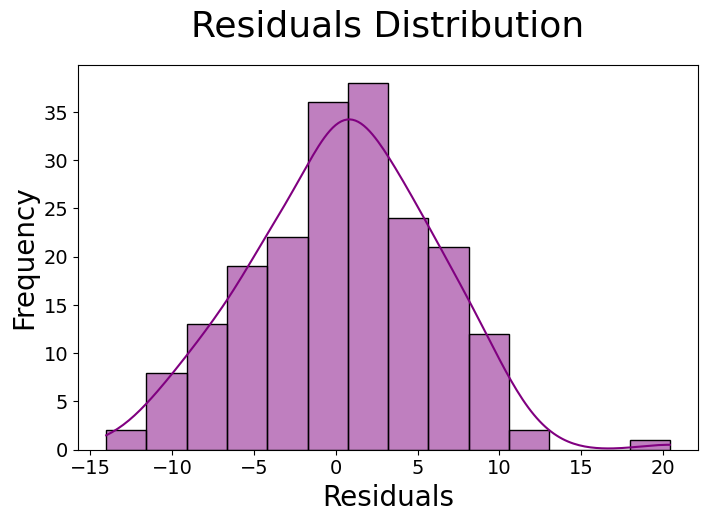

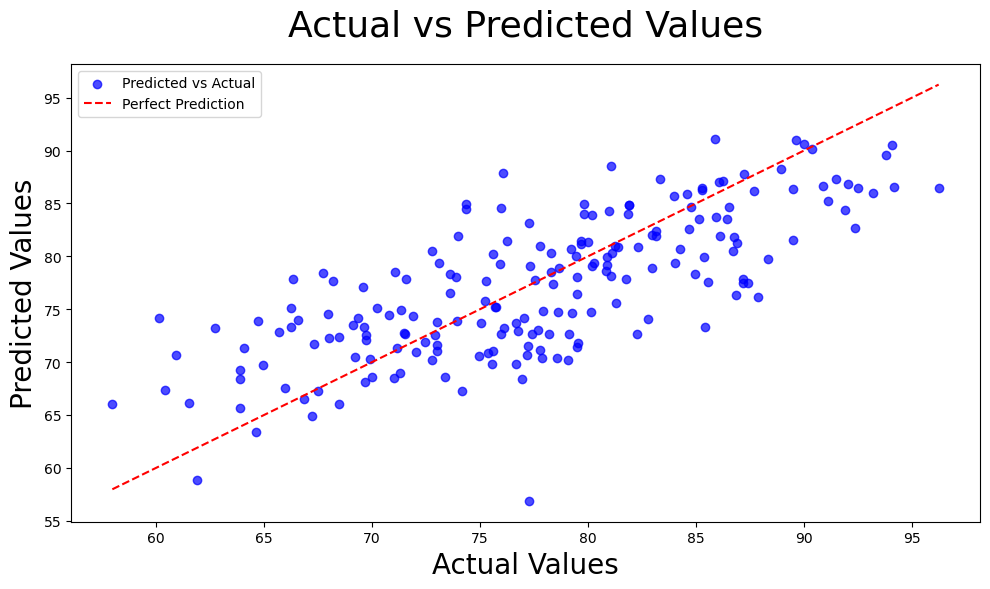

In [65]:
# XGBOOST without hypertuning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# Step 1: Prepare the data
# Define features (all columns except 'EnergyConsumption') and target (EnergyConsumption)
X = data_cleaned.drop(columns=['EnergyConsumption'])
y = data_cleaned['EnergyConsumption']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 2: Train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = model.predict(X_test) 

#Train the XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Step 4: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 5: Feature Importance Analysis
# plt.figure(figsize=(10, 6))
# xgboost_importances = xgb_model.feature_importances_
# feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgboost_importances})
# feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
# sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='pastel', hue='Feature')
# plt.title('XGBoost Feature Importance')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# Step 6: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution',fontsize= 26, pad = 20)
plt.xlabel('Residuals', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('Residual Plot (Error Analysis) XGBoost.png', dpi=300, bbox_inches='tight')
plt.show()


# Assuming y_test is the actual values and y_pred is the predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')

# Plot the line y = x (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Values',fontsize= 20)
plt.ylabel('Predicted Values',fontsize= 20)
plt.title('Actual vs Predicted Values',fontsize= 26 ,pad=20)
plt.savefig('Scatter plot of actual vs predicted values_XGboost.png', dpi=300, bbox_inches='tight')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()




In [40]:
# XGB with hypertuning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# Step 1: Prepare the data
# Define features (all columns except 'EnergyConsumption') and target (EnergyConsumption)
X = data_cleaned.drop(columns=['EnergyConsumption'])
y = data_cleaned['EnergyConsumption']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define the parameter grid for hypertuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Step 3: Initialize the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

# Step 4: Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)

# Step 5: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 6: Train the model with best parameters
best_model = grid_search.best_estimator_

# Step 7: Make predictions on the test set
y_pred = best_model.predict(X_test)

# Step 8: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 9: Feature Importance Analysis
# plt.figure(figsize=(10, 6))
# xgboost_importances = best_model.feature_importances_
# feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgboost_importances})
# feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
# sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='pastel', hue='Feature')
# plt.title('XGBoost Feature Importance')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

# Step 10: Residual Plot (Error Analysis)
# residuals = y_test - y_pred
# plt.figure(figsize=(8, 5))
# sns.histplot(residuals, kde=True, color='purple')
# plt.title('Residuals Distribution')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# Step 11: Prediction vs Actual Plot
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Line for perfect prediction
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Actual Energy Consumption')
# plt.ylabel('Predicted Energy Consumption')
# plt.grid(True)
# plt.show()


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Mean Absolute Error (MAE): 4.42
Mean Square Error (MSE): 30.27
Root Mean Squared Error (RMSE): 5.50
R² Score: 0.54


Mean Absolute Error (MAE): 4.59
Mean Square Error (MSE): 31.75
Root Mean Squared Error (RMSE): 5.64
R² Score: 0.51


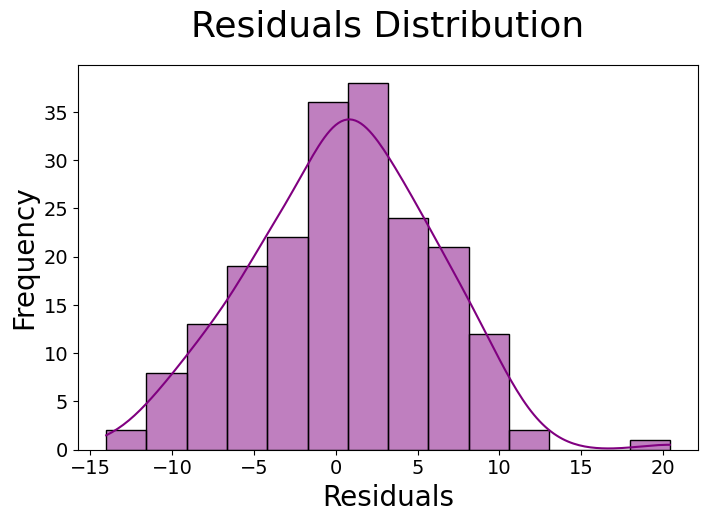

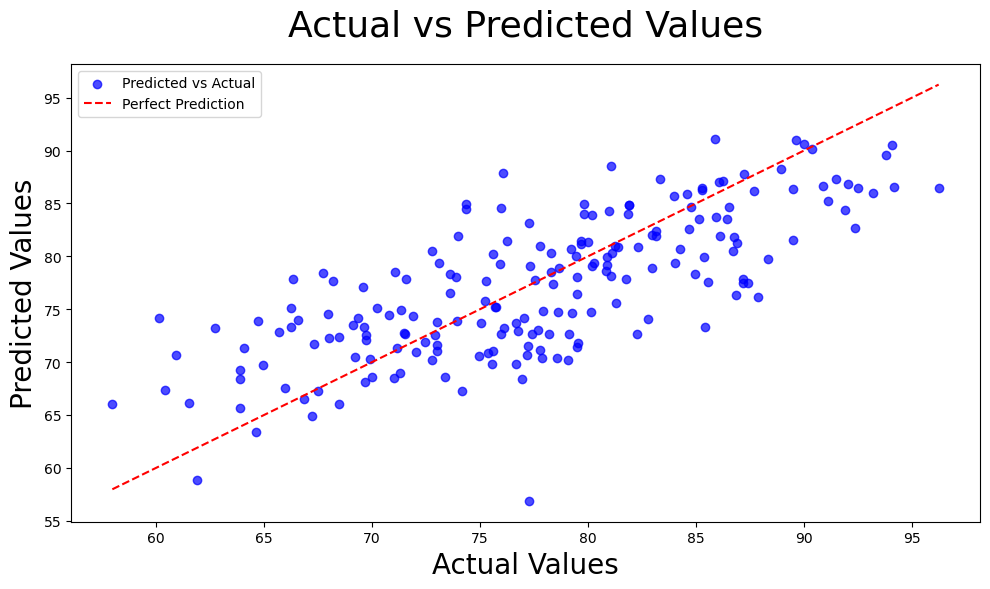

In [67]:
#support vector regressor

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Scale the data for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
svr = SVR(kernel='rbf')
#, C=100, gamma=0.1, epsilon=0.1)

# Fit the model on scaled training data
svr.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svr = svr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)


# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 6: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution',fontsize= 26, pad = 20)
plt.xlabel('Residuals', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('Residual Plot (Error Analysis) SVR.png', dpi=300, bbox_inches='tight')
plt.show()


# Assuming y_test is the actual values and y_pred is the predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')

# Plot the line y = x (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Values',fontsize= 20)
plt.ylabel('Predicted Values',fontsize= 20)
plt.title('Actual vs Predicted Values',fontsize= 26 ,pad=20)
plt.savefig('Scatter plot of actual vs predicted values_SVR.png', dpi=300, bbox_inches='tight')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.2]
}

# Initialize SVR
svr = SVR(kernel='rbf')

# Initialize GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Display the best parameters and score
print("Best Parameters:", grid_search.best_params_)
# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")

# Step 6: Residual Plot (Error Analysis)
# residuals = y_test - y_pred
# plt.figure(figsize=(8, 5))
# sns.histplot(residuals, kde=True, color='purple')
# plt.title('Residuals Distribution')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# Step 7: Prediction vs Actual Plot
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Line for perfect prediction
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Actual Energy Consumption')
# plt.ylabel('Predicted Energy Consumption')
# plt.grid(True)
# plt.show()


Best Parameters: {'C': 100, 'epsilon': 0.2, 'gamma': 0.001}
Tuned Model - Mean Absolute Error (MAE): 4.42
Tuned Model - Mean Squared Error (MSE): 30.27
Tuned Model - Root Mean Squared Error (RMSE): 5.50
Tuned Model - R² Score: 0.54


In [70]:
pip install scikit-optimize

   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   --- ------------------------------------ 10.2/107.8 kB ? eta -:--:--
   ------------------------------ --------- 81.9/107.8 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 107.8/107.8 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [44]:
#BayesSearchCV for svr

from skopt import BayesSearchCV
from sklearn.svm import SVR

# Define search space for parameters
search_space = {
   'C': (1e-6, 1e+6, 'log-uniform'),  # Log-uniform distribution for C
   'gamma': (1e-6, 1e+1, 'log-uniform'),  # Log-uniform distribution for gamma
    'epsilon': (0.01, 0.5)  # Epsilon range
}
#search_space = {
#    'C': (1e-2, 1e+2, 'log-uniform'),  # Narrow range for C
 #   'gamma': (1e-3, 1, 'log-uniform'),  # Narrow range for gamma
  #  'epsilon': (0.1, 0.5)  # Narrow range for epsilon
#}

# Initialize SVR
svr = SVR(kernel='rbf')

# Perform Bayesian optimization using BayesSearchCV
bayes_search = BayesSearchCV(svr, search_space, n_iter=50, cv=5, n_jobs=-1, n_points=5)
bayes_search.fit(X_train, y_train)

# Get the best model
best_svr_bayes = bayes_search.best_estimator_

# Best parameters and best score
print("Best Parameters:", best_svr_bayes)
# Make predictions
y_pred = best_svr_bayes.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")



KeyboardInterrupt: 

In [45]:
#RandomizedSearchCV  SVR
#v faster in results than bayesian search

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize SVR
svr = SVR(kernel='rbf')

# Define search space for parameters
search_space = {
   'C': (1e-6, 1e+6),  # Log-uniform distribution for C
   'gamma': ('scale', 'auto', 0.001, 0.01, 0.1, 1),  # Log-uniform distribution for gamma
    'epsilon': (0.01, 0.5)  # Epsilon range
}
# Perform Randomized Search using RandomizedSearchCV
randomized_search = RandomizedSearchCV(svr, search_space, n_iter=8, cv=3, n_jobs=-1, random_state=42)
randomized_search.fit(X_train, y_train)

# Get the best model
best_svr_random = randomized_search.best_estimator_

# Best parameters and best score
print("Best Parameters:", randomized_search.best_params_)

# Make predictions
y_pred = best_svr_random.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")


Best Parameters: {'gamma': 'scale', 'epsilon': 0.5, 'C': 1000000.0}
Tuned Model - Mean Absolute Error (MAE): 4.15
Tuned Model - Mean Squared Error (MSE): 26.86
Tuned Model - Root Mean Squared Error (RMSE): 5.18
Tuned Model - R² Score: 0.59


In [ ]:
#SearchCV  SVR
#v faster in results than bayesian search

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize SVR
svr = SVR(kernel='rbf')

# Define search space for parameters
search_space = {
   'C': (1e-6, 1e+6),  # Log-uniform distribution for C
   'gamma': ('scale', 'auto', 0.001, 0.01, 0.1, 1),  # Log-uniform distribution for gamma
    'epsilon': (0.01, 0.5)  # Epsilon range
}
# Perform Randomized Search using RandomizedSearchCV
randomized_search = RandomizedSearchCV(svr, search_space, n_iter=8, cv=3, n_jobs=-1, random_state=42)
randomized_search.fit(X_train, y_train)

# Get the best model
best_svr_random = randomized_search.best_estimator_

# Best parameters and best score
print("Best Parameters:", randomized_search.best_params_)

# Make predictions
y_pred = best_svr_random.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 4.14
Mean Square Error (MSE): 26.41
Root Mean Squared Error (RMSE): 5.14
R² Score: 0.59


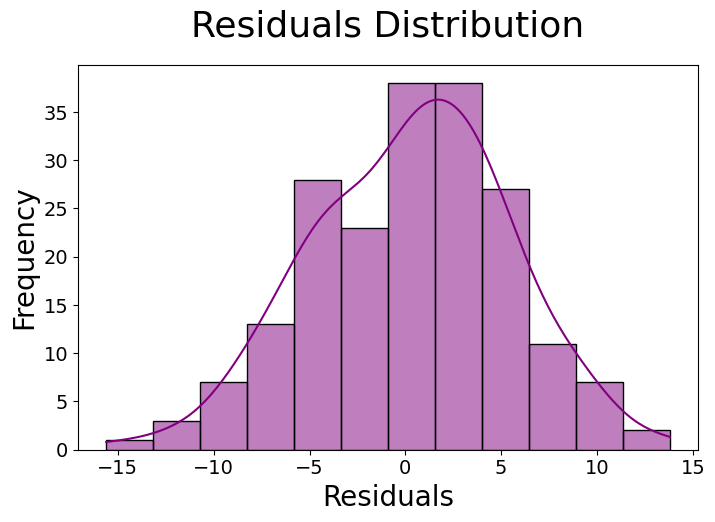

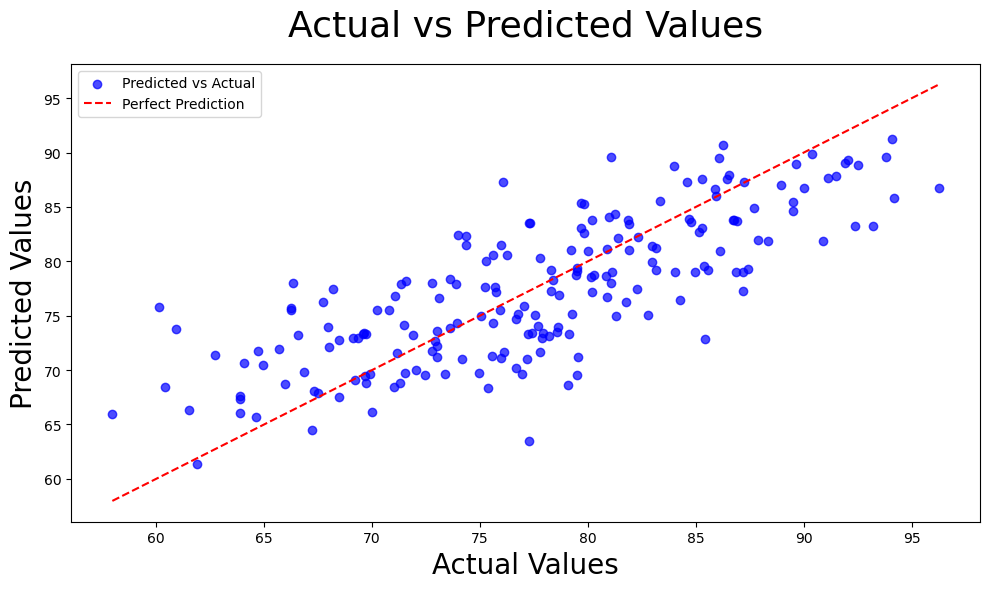

In [63]:
# Linear regression

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Square Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 5: Feature Importance Analysis
#plt.figure(figsize=(10, 6))
#xgboost_importances = xgb_model.feature_importances_
#feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgboost_importances})
#feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
#sns.barplot(x='Importance', y='Feature', data=feature_importances_df,palette='pastel' , hue='Feature')
#plt.title('Linear Regression')
#plt.xlabel('Importance Score')
#plt.ylabel('Features')
#plt.show()


# Calculate residuals (errors between actual and predicted values)
residuals = y_test - y_pred


# Step 6: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution',fontsize= 26, pad = 20)
plt.xlabel('Residuals', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('Residual Plot (Error Analysis) Linear regression.png', dpi=300, bbox_inches='tight')
plt.show()


# Assuming y_test is the actual values and y_pred is the predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')

# Plot the line y = x (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Values',fontsize= 20)
plt.ylabel('Predicted Values',fontsize= 20)
plt.title('Actual vs Predicted Values',fontsize= 26 ,pad=20)
plt.savefig('Scatter plot of actual vs predicted values_Linear regression.png', dpi=300, bbox_inches='tight')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [48]:
#Linear Regression GridSearchCV for hyperparameter tuning


from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Example pipeline with polynomial features and Ridge regression
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),  # Adjust degree as needed
    ('scaler', StandardScaler()),  # Scale features if necessary
    ('ridge', Ridge())  # Ridge regression with default alpha=1.0
])

# Parameters for GridSearchCV
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degree to try
    'ridge__alpha': [0.1, 1.0, 10.0]  # Regularization strength for Ridge regression
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
#print("Best Mean Squared Error:", -grid_search.best_score_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate performance metrics
# Evaluate the best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_= r2_score(y_test, y_pred)

# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")

Best Parameters: {'poly__degree': 1, 'ridge__alpha': 10.0}
Tuned Model - Mean Absolute Error (MAE): 4.14
Tuned Model - Mean Squared Error (MSE): 26.36
Tuned Model - Root Mean Squared Error (RMSE): 5.13
Tuned Model - R² Score: 0.59


Tuned Model - Mean Absolute Error (MAE): 4.19
Tuned Model - Mean Squared Error (MSE): 26.74
Tuned Model - Root Mean Squared Error (RMSE): 5.17
Tuned Model - R² Score: 0.59


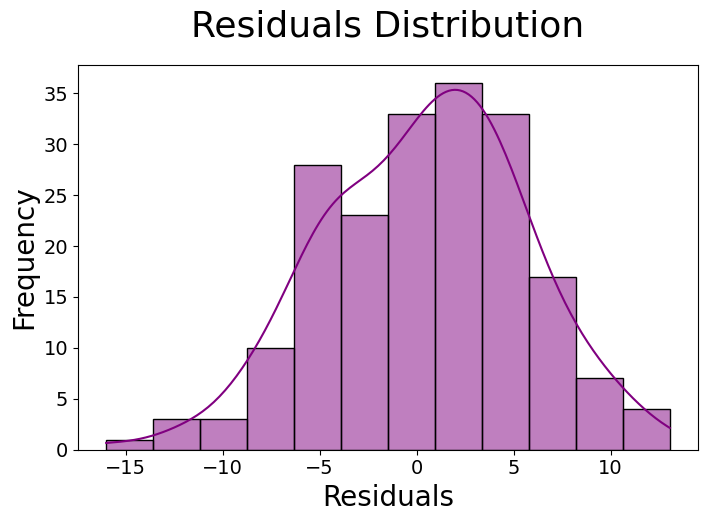

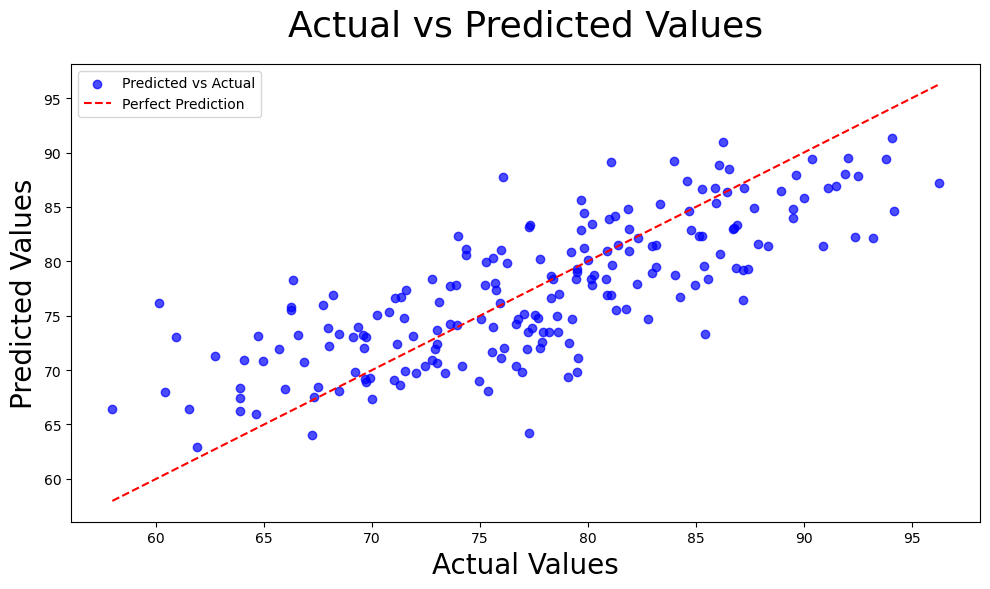

In [64]:
#Lasso Linear Regression


from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1)) # Default alpha value 
]) 
# Train the model
pipeline.fit(X_train, y_train) 

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate performance metrics
# Evaluate the best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_= r2_score(y_test, y_pred)

# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")

# Calculate residuals (errors between actual and predicted values)
residuals = y_test - y_pred


# Step 6: Residual Plot (Error Analysis)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution',fontsize= 26, pad = 20)
plt.xlabel('Residuals', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('Residual Plot (Error Analysis) lasso regression.png', dpi=300, bbox_inches='tight')
plt.show()


# Assuming y_test is the actual values and y_pred is the predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')

# Plot the line y = x (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Values',fontsize= 20)
plt.ylabel('Predicted Values',fontsize= 20)
plt.title('Actual vs Predicted Values',fontsize= 26 ,pad=20)
plt.savefig('Scatter plot of actual vs predicted values_Lasso regression.png', dpi=300, bbox_inches='tight')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming data_cleaned is already defined and preprocessed
X = data_cleaned.drop(columns=['EnergyConsumption'])
y = data_cleaned['EnergyConsumption']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define the parameter grid for hypertuning
param_grid = { 'lasso__alpha': np.logspace(-4, 4, 50) }
 # More refined range for alpha

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Tuned Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Tuned Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Tuned Model - R² Score: {r2:.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'lasso__alpha': 0.18420699693267145}
Tuned Model - Mean Absolute Error (MAE): 4.16
Tuned Model - Mean Squared Error (MSE): 26.39
Tuned Model - Root Mean Squared Error (RMSE): 5.14
Tuned Model - R² Score: 0.60


In [1]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.
